# I. Boosting Trees from Scratch
* Use the scikit-learn's DecisionTreeRegressor with `max_depth = 1` (stumps)  to write a L2Boost model which minimize the L2 square loss iteration by iteration.
Reminder: in each step, build a decision tree to minimize the error between the true label and the accumulated (sum) of the previous step predictions.
![alt text](https://explained.ai/gradient-boosting/images/latex-321A7951E78381FB73D2A6874916134D.svg)
* Use the Boston dataset to plot the MSE as a function of the number of trees for a logspace of `n_trees` up to 1,000. What is the optimal value of `n_trees`? of learning rate?
* Compare the performance with a deep DecisionTreeRegressor (find the optimal `max_depth`).  Who wins?
* **Optional**: add an early-stopping mechanisim to the GBTL2 model to use a validation set to detect over-fit.

n_trees: 100%|██████████| 18/18 [00:02<00:00,  7.07it/s]


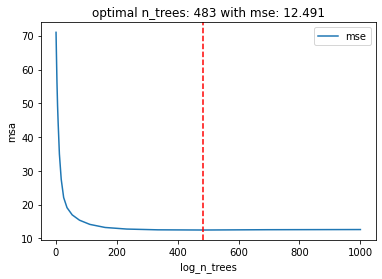

l_rate: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]


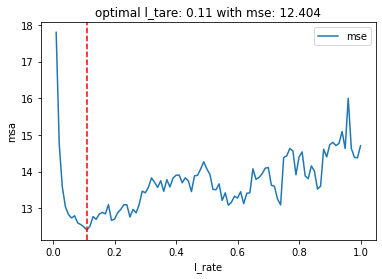

max_depth: 100%|██████████| 31/31 [00:29<00:00,  1.06it/s]


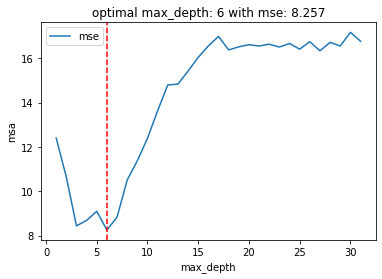

ERROR: Cannot find key: -f
Usage: ipykernel_launcher.py <group|command|value>
  available groups:      In | Out | exit | quit | data | pd | df | clf | sys |
                         fire | np | plt
  available commands:    get_ipython | load_boston | DecisionTreeRegressor |
                         accuracy_score | mean_absolute_error |
                         train_test_split | mean_squared_error | tqdm |
                         L2Boost | main
  available values:      X | y | y_hat | X_train | X_test | y_train | y_test

For detailed information on this command, run:
  ipykernel_launcher.py --help


FireExit: 2

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [40]:
import fire
from sklearn.datasets import load_boston
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


class L2Boost(object):

    def __init__(self, max_depth, n_trees, l_rate):
        self.max_depth = max_depth
        self.n_tree = n_trees
        self.l_rate = l_rate
        self.predictions_list = []
        self.trees_list = []
        self.mean = None

    def fit(self, X, y):

        self.mean = y.mean()
        prediction = self.mean
        self.predictions_list.append(prediction)
        residuals = y - prediction

        for i in range(self.n_tree):

            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)

            prediction = tree.predict(X)
            scaled_prediction = prediction * self.l_rate
            self.predictions_list.append(scaled_prediction)
            residuals = y - sum(self.predictions_list)

            self.trees_list.append(tree)

    def predict(self, X):
        return self.mean + np.sum([clf.predict(X) * self.l_rate for clf in self.trees_list], axis=0)


def main(max_depth, l_rate):

    data = load_boston()
    X, y = data['data'], data['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    trees_list = []
    l_rate_list = []
    max_depth_list = []

    max_depth_rage = np.unique(np.logspace(0, np.log2(1000), base=2, num=20).astype('int'))

    pbar = tqdm(total=len(max_depth_rage), desc="n_trees")

    for tree_num in max_depth_rage:
        pbar.update(1)
        clf = L2Boost(max_depth, tree_num, l_rate)
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        trees_list.append({'mse': mean_squared_error(y_hat, y_test), 'log_n_trees': tree_num})

    pbar.close()

    trees_results_df = pd.DataFrame(trees_list).set_index('log_n_trees')
    optimal_n_tree = trees_results_df.idxmin().iloc[0]
    optimal_mse = round(trees_results_df[trees_results_df.index == optimal_n_tree]['mse'].iloc[0], 3)
    trees_results_df.plot()
    plt.title('optimal n_trees: %s with mse: %s' % (optimal_n_tree, optimal_mse))
    plt.axvline(optimal_n_tree, color='r', linestyle='--')
    plt.ylabel('msa')
    plt.show()

    l_rate_range = np.linspace(0.01, 1, 100)

    pbar = tqdm(total=len(l_rate_range), desc="l_rate")

    for l_rate in l_rate_range:
        pbar.update(1)
        clf = L2Boost(max_depth, optimal_n_tree, l_rate)
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        l_rate_list.append({'mse': mean_squared_error(y_hat, y_test), 'l_rate': l_rate})

    pbar.close()

    l_tare_results_df = pd.DataFrame(l_rate_list).set_index('l_rate')

    optimal_l_rate = l_tare_results_df.idxmin().iloc[0]
    optimal_mse = round(l_tare_results_df[l_tare_results_df.index == optimal_l_rate]['mse'].iloc[0], 3)
    l_tare_results_df.plot()
    plt.title('optimal l_tare: %s with mse: %s' % (optimal_l_rate, optimal_mse))
    plt.axvline(optimal_l_rate, color='r', linestyle='--')
    plt.ylabel('msa')
    plt.show()

    max_depth_rage = range(1, 32)

    pbar = tqdm(total=len(max_depth_rage), desc="max_depth")

    for max_depth in max_depth_rage:
        pbar.update(1)
        clf = L2Boost(max_depth, optimal_n_tree, optimal_l_rate)
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        max_depth_list.append({'mse': mean_squared_error(y_hat, y_test), 'max_depth': max_depth})

    pbar.close()

    max_depth_results_df = pd.DataFrame(max_depth_list).set_index('max_depth')

    optimal_max_depth = max_depth_results_df.idxmin().iloc[0]
    optimal_mse = round(max_depth_results_df[max_depth_results_df.index == optimal_max_depth]['mse'].iloc[0], 3)
    max_depth_results_df.plot()
    plt.title('optimal max_depth: %s with mse: %s' % (optimal_max_depth, optimal_mse))
    plt.axvline(optimal_max_depth, color='r', linestyle='--')
    plt.ylabel('msa')
    plt.show()

if __name__ == '__main__':
    fire.Fire(main(max_depth=1, l_rate=0.1))


# II. AdaBoost From Scratch
# We did not cover this material during the lecture. Thus this part is optional, if time permits. Bonus (20 points)


*   Implement the AdaBoost algorithm for classification task. Your `AdaBoost` class should receive a method for creating a weak learner, which has a fit and predict methods (**hint**: you can simulate re-weighting of the samples by an appropriate re-sampling of the train set).
*   Use your model to find a strong classifier on the sample set given below, using $n$ weak learners:
    - For the base weak learners, use a ***linear*** SVM classifier (use `LinearSVC` with the default parameters). 
    - Split the sample set into train and test sets.
    - Plot the final decision plane of your classifier for $n\in \{1, 2, 3, 5, 10, 50\}$, and visualize the final iteration weights of the samples in those plots.
    - How does the overall train set accuracy changes with $n$?
    - Does you model starts to overfit at some point?


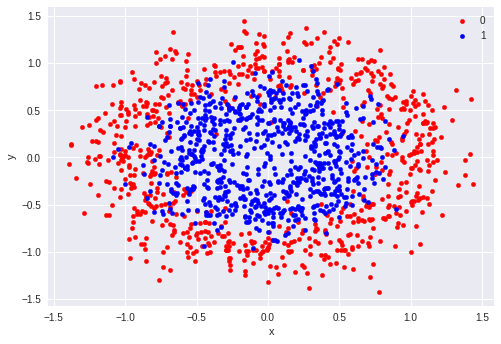

In [ ]:
from sklearn.datasets import make_circles
from matplotlib import pyplot
from pandas import DataFrame

# generate 2d classification dataset
X, y = make_circles(n_samples=1500, noise=0.2, random_state=101, factor=0.5)

# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [ ]:
# Answer...